# Projeto de Séries Temporais
## Chuvas no município de São Paulo
### João Honorato, Maria Raquel

Estamos usando dados mensais de precipitação de chuva no município de São Paulo, extraídos do Departamento de Águas e Energia Elétrica (DAEE), do período de 1985 a 2022 

link: http://www.hidrologia.daee.sp.gov.br/

A chuva é medida em milímetros, 1 mm de altura de chuva equivale ao volume de 1 litro precipitado sobre uma superfície de 1 m² de área.

As alturas mensais de chuva são as acumuladas entre 7 horas do último dia do mês anterior até às 7 horas do último dia do mês considerado.

In [1]:
import numpy as np
import pandas as pd

### Carregando e tratando os dados

In [2]:
# Carregando os dados

chuvasp = pd.read_csv('E3-262_Chuva_Mensal_Serie_20230830_084446.csv', sep=';')
chuvasp.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,"184,90","242,90","230,00","59,00","126,20","14,60","4,00","21,80","126,10","71,10","111,30","155,20"
1,1986,"199,60","221,00","218,70","106,50","113,10","3,90","30,30",---,"34,50","60,70","242,50","389,90"
2,1987,"525,80",---,"161,30","98,10","293,80","183,90","11,80","30,90","80,20","84,80","72,70","152,10"
3,1988,"268,70","224,40","189,20","175,10","224,90","58,60","1,30","0,20","28,40","173,90","100,20","289,80"
4,1989,"312,90","344,30","288,20","66,30","21,70","52,50","150,10","32,90","52,10","80,10","88,00","236,70"


In [3]:
# Precisamos substituir as vírgulas por pontos para converter os valores para float

chuvasp = chuvasp.replace(',','.', regex=True)
chuvasp.head()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
0,1985,184.90,242.90,230.00,59.00,126.20,14.60,4.00,21.80,126.10,71.10,111.30,155.20
1,1986,199.60,221.00,218.70,106.50,113.10,3.90,30.30,---,34.50,60.70,242.50,389.90
2,1987,525.80,---,161.30,98.10,293.80,183.90,11.80,30.90,80.20,84.80,72.70,152.10
3,1988,268.70,224.40,189.20,175.10,224.90,58.60,1.30,0.20,28.40,173.90,100.20,289.80
4,1989,312.90,344.30,288.20,66.30,21.70,52.50,150.10,32.90,52.10,80.10,88.00,236.70


In [4]:
# De acordo com o DAEE, valores com '---' representam dados inexistentes.
# Vamos substituí-los pela de chuvas de cada mês, dado presente na última linha do dataset

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
34,2019,---,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,---
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,---,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40
38,Média:,309.01,249.32,228.13,92.24,84.89,58.09,51.79,28.56,85.08,139.63,145.48,235.36


In [5]:
for coluna, i in zip(chuvasp.columns, range(14)):
    chuvasp[coluna] = chuvasp[coluna].str.replace('---', f'{chuvasp.iloc[-1][i]}')

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
34,2019,309.01,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,235.36
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,85.08,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40
38,Média:,309.01,249.32,228.13,92.24,84.89,58.09,51.79,28.56,85.08,139.63,145.48,235.36


In [6]:
valores_medios = chuvasp.iloc[-1][1:].values.astype(float)
valores_medios

array([309.01, 249.32, 228.13,  92.24,  84.89,  58.09,  51.79,  28.56,
        85.08, 139.63, 145.48, 235.36])

In [7]:
# Excluiremos a última linha
chuvasp = chuvasp.drop(chuvasp[chuvasp['Ano'] == '  Média:'].index)

chuvasp.tail()

,Ano,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
33,2018,238.20,84.50,228.13,66.40,25.80,15.00,20.50,28.56,72.90,203.40,134.10,258.00
34,2019,309.01,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,2020,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,235.36
36,2021,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,85.08,152.80,108.20,247.40
37,2022,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40


In [8]:
# Excluiremos a coluna ano
chuvasp = chuvasp.drop(columns=['Ano'])

chuvasp.tail()

,Janeiro,Fevereiro,Março,Abril,Maio,Junho,Julho,Agosto,Setembro,Outubro,Novembro,Dezembro
33,238.20,84.50,228.13,66.40,25.80,15.00,20.50,28.56,72.90,203.40,134.10,258.00
34,309.01,315.50,318.50,172.30,97.30,59.00,195.10,6.70,73.70,75.90,170.80,249.00
35,408.10,363.00,95.50,5.60,13.70,163.80,10.20,62.10,22.90,213.90,162.10,235.36
36,373.30,174.10,137.80,55.70,38.50,15.50,38.00,44.80,85.08,152.80,108.20,247.40
37,418.40,136.30,233.60,40.40,67.30,45.90,8.80,35.20,131.30,117.30,197.70,200.40


In [9]:
# Convertendo os valores para float

chuvasp = chuvasp.astype(float)

In [10]:
valores = list(chuvasp.values.flatten())
print(valores)

[184.9, 242.9, 230.0, 59.0, 126.2, 14.6, 4.0, 21.8, 126.1, 71.1, 111.3, 155.2, 199.6, 221.0, 218.7, 106.5, 113.1, 3.9, 30.3, 28.56, 34.5, 60.7, 242.5, 389.9, 525.8, 249.32, 161.3, 98.1, 293.8, 183.9, 11.8, 30.9, 80.2, 84.8, 72.7, 152.1, 268.7, 224.4, 189.2, 175.1, 224.9, 58.6, 1.3, 0.2, 28.4, 173.9, 100.2, 289.8, 312.9, 344.3, 288.2, 66.3, 21.7, 52.5, 150.1, 32.9, 52.1, 80.1, 88.0, 236.7, 284.1, 196.9, 310.1, 85.8, 77.9, 50.6, 121.2, 76.3, 97.2, 206.8, 116.3, 149.8, 330.7, 340.3, 522.4, 200.3, 43.3, 96.8, 28.2, 37.3, 101.4, 168.0, 67.3, 237.9, 129.2, 258.5, 228.13, 87.2, 93.5, 11.6, 40.9, 24.7, 150.6, 219.6, 145.48, 211.7, 221.5, 225.7, 110.0, 84.6, 133.9, 74.7, 11.2, 40.8, 210.1, 134.1, 125.5, 170.5, 196.9, 184.4, 231.6, 111.4, 54.9, 30.5, 39.2, 2.4, 1.8, 147.6, 86.6, 276.3, 373.8, 383.1, 267.7, 73.9, 79.7, 31.2, 46.8, 1.5, 44.2, 202.6, 115.1, 235.36, 334.3, 376.5, 284.5, 42.3, 21.7, 45.1, 12.2, 41.2, 179.4, 179.8, 87.4, 243.9, 235.0, 187.6, 57.1, 63.2, 88.2, 124.7, 12.5, 28.8, 118.0,

In [11]:
anos = pd.date_range('1985', periods = len(valores), freq = 'M')
anos

DatetimeIndex(['1985-01-31', '1985-02-28', '1985-03-31', '1985-04-30',
               '1985-05-31', '1985-06-30', '1985-07-31', '1985-08-31',
               '1985-09-30', '1985-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=456, freq='M')

In [12]:
serie = pd.Series(valores, index = anos)
serie

1985-01-31    184.9
1985-02-28    242.9
1985-03-31    230.0
1985-04-30     59.0
1985-05-31    126.2
              ...  
2022-08-31     35.2
2022-09-30    131.3
2022-10-31    117.3
2022-11-30    197.7
2022-12-31    200.4
Freq: M, Length: 456, dtype: float64

In [13]:
meses = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov','Dez']
serie_medias = pd.Series(valores_medios, index = meses)
serie_medias

Jan    309.01
Fev    249.32
Mar    228.13
Abr     92.24
Mai     84.89
Jun     58.09
Jul     51.79
Ago     28.56
Set     85.08
Out    139.63
Nov    145.48
Dez    235.36
dtype: float64

### Gráficos da série temporal

In [14]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=serie.index, y=serie.values,
                    mode='lines',
                    name='lines'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

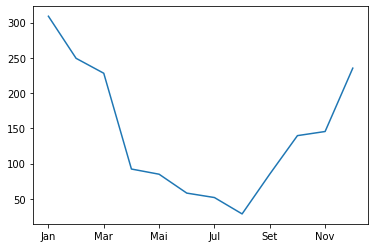

In [15]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 10)
serie_medias.plot();

### Média móvel

A média móvel é utilizada para suavizar grandes desvios e auxiliar a identificação de tendências nos dados. Usaremos a média móvel dos últimos seis meses no presente trabalho.

In [16]:
media_movel = serie.rolling(window = 6)
media_movel = media_movel.mean()

In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=media_movel.index, y=media_movel.values,
                    mode='lines',
                    name='lines'))
fig.update_layout(title='Média móvel de 6 meses das chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=serie.index, y=serie.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=media_movel.index, y=media_movel.values,
                    mode='lines',
                    name='Média móvel'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

### Decomposição

Vamos decompor a série em tendência, sazonalidade e resíduos:

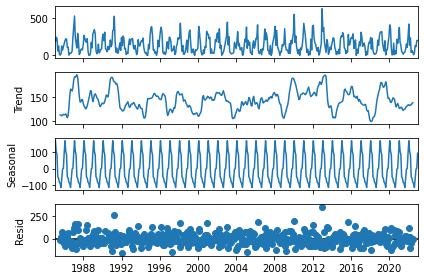

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposicao = seasonal_decompose(serie)
decomposicao.plot();

Observações:

- Tendência apresenta muitas oscilações, não demonstrando comportamento crescente ou decrescente
- Além disso, a tendência não possui ciclos bem definidos, dado o seu comportamento oscilatório
- Forte sazonalidade, com picos constantes e intervalos bem definidos (aproximadamente um ano)
- Resíduos serão utilizados para construção e validação dos modelos

### Normalidade

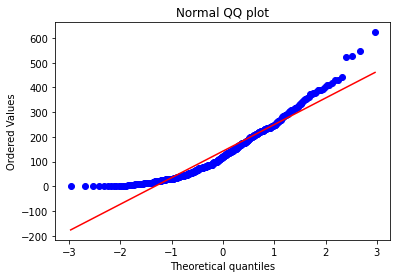

In [20]:
import scipy.stats as stats
stats.probplot(serie, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Graficamente, notamos que os dados não seguem uma distribuição normal. Mesmo assim, faremos um teste de hipóteses para verificação da normalidade da série. Usaremos o teste de Shapiro-Wilk, ideal para o tamanho da amostra, com nível de significância de 5%.

**Teste Shapiro-Wilk**


- H0 = distribuição normal p > 0,05
- H1 = distribuição não normal p <= 0,05

In [21]:
e, p = stats.shapiro(serie)
print(f'Estátistica de teste: {e:.4f}')
print(f'p-valor: {p:.4e}')

Estátistica de teste: 0.9243
p-valor: 2.1459e-14


De fato, os dados não seguem uma distribuição normal.

Para fazer com que a série se aproxime de uma distribuição normal, faremos uma transformação por raiz cúbica. Assim, criaremos uma nova série, composta pela raiz cúbica dos dados originais.

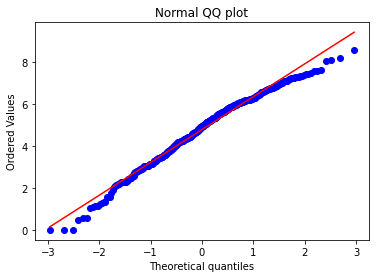

In [22]:
serie_n = (serie)**(1/3)
stats.probplot(serie_n, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Após a transformação, os dados já estão mais próximos de uma distribuição normal. Para comprovar isso, repetiremos o teste de Shapiro-Wilk.

In [23]:
e, p = stats.shapiro(serie_n)
print(f'Estátistica de teste: {e:.4f}')
print(f'p-valor: {p:.4e}')

Estátistica de teste: 0.9843
p-valor: 7.8649e-05


Ainda não obtivemos uma distribuição normal, mas estamos mais próximos do que a série original.

C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\103337203.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




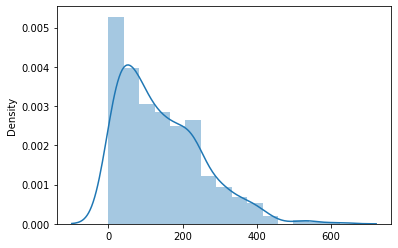

In [24]:
import seaborn as sns

sns.distplot(serie);

C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\4180245685.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




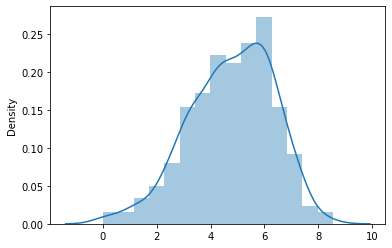

In [25]:
sns.distplot(serie_n);

### Estacionariedade

Estacionariedade é a característica de séries que se desenvolvem no tempo através de uma média/variância constante.

Séries não estacionárias costumam seguir uma tendência e mudam de comportamento por inclinação ou mudança de nível no gráfico.

Para determinar a estacionariedade de uma série, utilizamos testes estatísticos. Para a nossa série, usaremos o teste KPSS.

**Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin)**

- H0 = não é estacionário: estatística do teste > valor crítico
- H1 = é estacionário:  estatística do teste < valor crítico

Para escolha do valor crítico, utilizaremos o valor de referência para 5%

In [26]:
import statsmodels.tsa.stattools

kpss = statsmodels.tsa.stattools.kpss(serie_n)
print('Estatítica do teste: {:.4f}'.format(kpss[0]))
print('p_valor: {:.4f}'.format(kpss[1]))
print('Valores Críticos:')
for chave, valor in kpss[3].items():
    print('{}: {:.4f}'.format(chave, valor))

Estatítica do teste: 0.0166
p_valor: 0.1000
Valores Críticos:
10%: 0.3470
5%: 0.4630
2.5%: 0.5740
1%: 0.7390


C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\2338894414.py:3: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Como a estatística de teste deu um valor inferior ao valor crítico para 5%, temos que a série **É ESTACIONÁRIA**

Dessa forma, não será necessário fazer a diferenciação.

### Autocorrelação

A autocorrelação ocorre quando há **correlação entre determinados períodos anteriores com o período atual.**

Períodos com autocorrelação são chamados de lags.

A análise de autocorrelação dos resíduos é um **pressuposto para construção e validação de modelos preditivos.**


Para verificar a autocorrelação, utilizaremos os **diagramas ACF e PACF.**


Veremos nos diagramas abaixo que série **é autocorrelacionada**, com valores acima do intervalo de confiança.

Isso não será um problema, pois esse é um pressuposto da análise dos resíduos dos modelos de séries temporais.

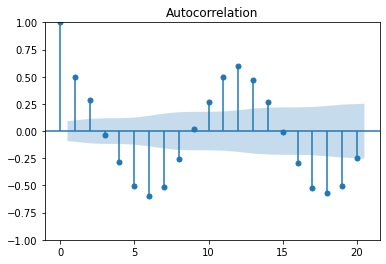

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(serie_n, lags=20)
plt.show()

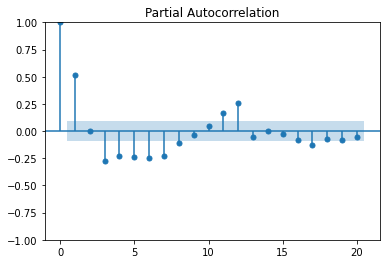

In [28]:
plot_pacf(serie, lags=20)
plt.show()

Modelos ARIMA não sazonais são geralmente denotados como ARIMA( p , d , q), em que os parâmetros p, d e q são números inteiros não negativos, p é a ordem (número de defasagens) do modelo auto-regressivo, d é o grau de diferenciação (o número de vezes em que os dados tiveram valores passados subtraídos) e q é a ordem do modelo de média móvel. Modelos ARIMA sazonais são geralmente denotados como ARIMA( p , d , q )( P , D , Q) m, em que m se refere ao número de períodos em cada temporada e P, D e Q se referem aos termos de auto-regressão, diferenciação e média móvel para a parte sazonal do modelo ARIMA.

## **Modelo AR**

Modelos ARIMA não sazonais são geralmente denotados como ARIMA(p, d, q), em que o parâmetro p é a ordem do modelo auto-regressivo, d é o grau de diferenciação e q é a ordem do modelo de média móvel.


O modelo AR (Auto-Regressivo) indica que a variável evoluinte de interesse é regressada em seus próprios valores anteriores.

Ele é um modelo ARIMA nos quais os parâmetros d e q são nulos e o parâmetro p não.

AIC (Critério de Informação de Akaike) e BIC (Critério de Informação Bayesiano) são métricas que mensuram a qualidade de um modelo estatístico. Quanto menor for o AIC e BIC, melhor é o modelo.



In [29]:
from statsmodels.tsa.arima.model import ARIMA

for p in range(1, 11):
    modelo_ar = ARIMA(serie_n, order = (p,0,0))
    teste = modelo_ar.fit()
    print(f'ARIMA({p},0,0) - AIC: {teste.aic:.4f}')

ARIMA(1,0,0) - AIC: 1577.9084
ARIMA(2,0,0) - AIC: 1578.8461
ARIMA(3,0,0) - AIC: 1548.7956
ARIMA(4,0,0) - AIC: 1515.7202
ARIMA(5,0,0) - AIC: 1468.4165
ARIMA(6,0,0) - AIC: 1422.5240
ARIMA(7,0,0) - AIC: 1397.3217
ARIMA(8,0,0) - AIC: 1398.1132
ARIMA(9,0,0) - AIC: 1400.0770
ARIMA(10,0,0) - AIC: 1402.0718


In [30]:
modelo_ar = ARIMA(serie_n, order = (7,0,0))
resultado = modelo_ar.fit()
print(resultado.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -689.661
Date:                Sun, 17 Sep 2023   AIC                           1397.322
Time:                        20:34:14   BIC                           1434.424
Sample:                    01-31-1985   HQIC                          1411.937
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7753      0.035    136.208      0.000       4.707       4.844
ar.L1          0.1488      0.044      3.420      0.001       0.064       0.234
ar.L2          0.0826      0.049      1.679      0.0

### Análise dos Resíduos

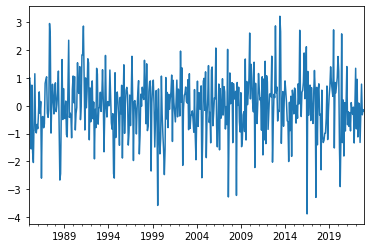

In [31]:
residuos = resultado.resid
residuos.plot();

Média em torno do zero, com pouca tendência

Resíduos bem concentrados, estáveis

#### Normalidade

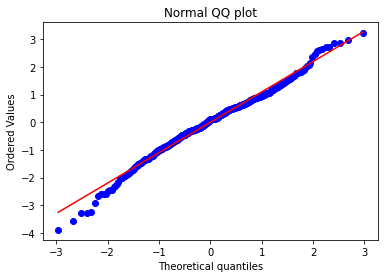

In [32]:
stats.probplot(residuos, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

Graficamente, a série aparenta se aproximar de uma distribuição normal. Façamos o teste de Shapiro-Wilk para verificar:

In [33]:
e, p = stats.shapiro(residuos)
print(f'Estátistica de teste: {e:.4f}')
print(f'p-valor: {p:.4e}')

Estátistica de teste: 0.9882
p-valor: 9.6014e-04


Isso indica que a distribuição dos resíduos **não é normal**

C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\1081090613.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




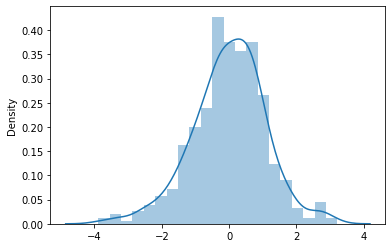

In [34]:
sns.distplot(residuos);

#### Autocorrelação

Analisemos a autocorrelação dos resíduos usando ACF e PACF:

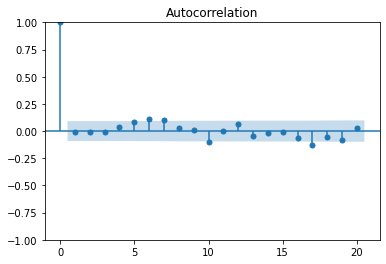

In [35]:
plot_acf(residuos, lags=20)
plt.show()

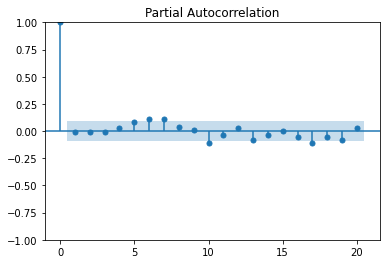

In [36]:
plot_pacf(residuos, lags=20)
plt.show()

Como todos os pontos de ambos os gráficos estão muito próximos do intervalo de confiança, concluímos que os resídios **não possuem autocorrelação**

In [37]:
fig = go.Figure()
_ = serie_n-residuos
fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

### Previsão

In [38]:
resultado.fittedvalues

1985-01-31    4.775259
1985-02-28    5.232342
1985-03-31    5.511358
1985-04-30    5.444211
1985-05-31    4.271934
                ...   
2022-08-31    3.470902
2022-09-30    4.304046
2022-10-31    5.219104
2022-11-30    5.962153
2022-12-31    6.044677
Freq: M, Length: 456, dtype: float64

In [39]:
resultado.fittedvalues
previsao = resultado.predict(start=455, end=467)
_ = serie_n-residuos

fig = go.Figure()
fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.add_trace(go.Scatter(x=previsao.index, y=previsao,
                    mode='lines',
                    name='Previsão AR'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

O plot acima leva em consideração os dados transformados (raiz cúbica). Vamos plotar e guardar a previsão em seus valores originais:

In [40]:
prev_escala = pd.DataFrame(previsao**3)
prev_escala.columns = ['Modelo_AR']
prev_escala

,Modelo_AR
2022-12-31,220.861124
2023-01-31,244.711105
2023-02-28,212.495039
2023-03-31,134.824453
2023-04-30,84.096060
2023-05-31,63.185530
2023-06-30,49.186479
2023-07-31,49.778316
2023-08-31,59.255553
2023-09-30,86.892739


Agora, o plot com os dados corrigidos:

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=serie.index, y=serie.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=prev_escala.index, y=prev_escala['Modelo_AR'],
                    mode='lines',
                    name='Previsão'))

**Problemas do modelo:**
* resíduos não seguem uma distribuição normal

## **Modelo MA**

Modelo ARIMA: (p,d,q)

Modelo MA: (0,0,q)

O modelo de Média Móvel (MA) é uma abordagem importante na análise e previsão de séries temporais. Diferentemente do modelo AR (Auto-Regressivo), o modelo MA baseia-se na premissa de que **o valor atual de uma série temporal é influenciado por ruídos aleatórios ou erros residuais de previsões passadas.** Em um modelo MA, a previsão é feita calculando-se uma média ponderada desses erros residuais anteriores, onde a ordem do modelo, representada como MA(q), determina quantos períodos anteriores são considerados.

In [42]:
for q in range(1, 11):
    modelo_ma = ARIMA(serie_n, order = (0,0,q))
    teste = modelo_ma.fit()
    print(f'ARIMA(0,0,{q}) - AIC: {teste.aic:.4f}')

ARIMA(0,0,1) - AIC: 1617.1496
ARIMA(0,0,2) - AIC: 1569.7491


ARIMA(0,0,3) - AIC: 1564.5801
ARIMA(0,0,4) - AIC: 1560.3805
ARIMA(0,0,5) - AIC: 1551.8963
ARIMA(0,0,6) - AIC: 1522.1238
ARIMA(0,0,7) - AIC: 1487.2752
ARIMA(0,0,8) - AIC: 1483.0080
ARIMA(0,0,9) - AIC: 1484.8854
ARIMA(0,0,10) - AIC: 1486.7897


O menor valor de AIC foi obtido com q = 8

In [43]:
modelo_ma = ARIMA(serie_n, order = (0,0,8))

In [44]:
resultado_ma = modelo_ma.fit()
print(resultado_ma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:                 ARIMA(0, 0, 8)   Log Likelihood                -731.504
Date:                Sun, 17 Sep 2023   AIC                           1483.008
Time:                        20:34:20   BIC                           1524.233
Sample:                    01-31-1985   HQIC                          1499.247
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7810      0.027    179.646      0.000       4.729       4.833
ma.L1          0.3085      0.049      6.300      0.000       0.213       0.405
ma.L2          0.2319      0.049      4.737      0.0

### Análise dos resíduos

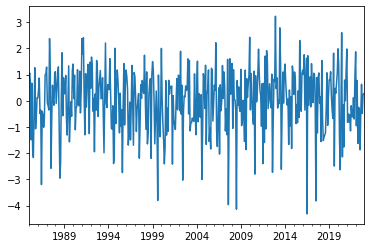

In [45]:
residuos_ma = resultado_ma.resid
residuos_ma.plot()
plt.show()

Os resíduos aparentam ter uma média em torno de zero, com pouca tendência.

#### Normalidade

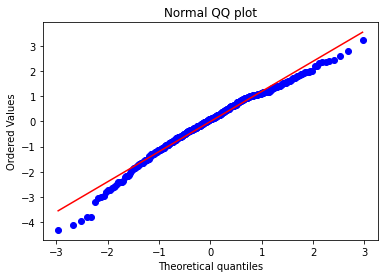

In [46]:
stats.probplot(residuos_ma, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\656102450.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




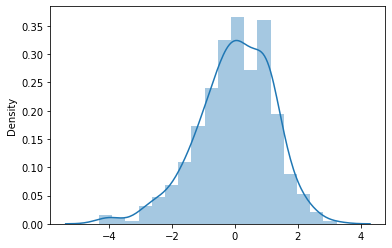

In [47]:
sns.distplot(residuos_ma);

In [48]:
e, p = stats.shapiro(residuos_ma)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9808076024055481
p-valor: 9.943053555616643e-06


Os resíduos **não seguem uma distribuição normal**

#### Autocorrelação

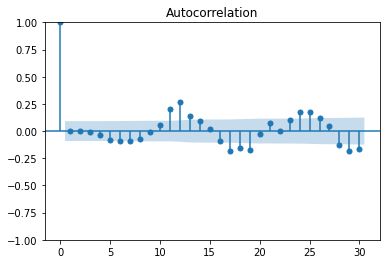

In [49]:
plot_acf(residuos_ma, lags=30)
plt.show()

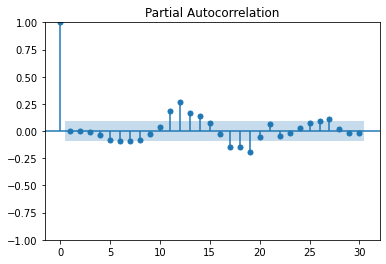

In [50]:
plot_pacf(residuos_ma, lags=30)
plt.show()

Verificando os gráficos do ACF e do PACF, notamos que alguns valores estão fora do intervalo de confiança, apontando para a **existência de autocorrelação nos resíduos**, mesmo que fraca

In [51]:
fig = go.Figure()
_ = serie_n-residuos_ma
fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

### Previsão

In [52]:
resultado_ma.fittedvalues
previsao_ma = resultado_ma.predict(start=455, end=467)

fig = go.Figure()
fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.add_trace(go.Scatter(x=previsao_ma.index, y=previsao_ma,
                    mode='lines',
                    name='Previsão MA'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

In [53]:
prev_escala['Modelo_MA'] = previsao_ma**3
prev_escala.head()

,Modelo_AR,Modelo_MA
2022-12-31,220.861124,173.613405
2023-01-31,244.711105,185.384784
2023-02-28,212.495039,171.885718
2023-03-31,134.824453,126.449308
2023-04-30,84.096060,103.787111


In [54]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=serie.index, y=serie.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=prev_escala.index, y=prev_escala['Modelo_MA'],
                    mode='lines',
                    name='Previsão'))

**Problemas do modelo:**
* resíduos não seguem uma distribuição normal
* autocorrelação dos resíduos

## **Modelo ARMA**

Modelo ARIMA: (p,d,q)

Modelo ARMA: (p,0,q)




O modelo ARMA combina um componente autoregressivo (AR), que tenta explicar **a influência dos valores passados na série atual** com um componente de média móvel (MA), **que tenta capturar os erros das previsões passadas.**


In [55]:
modelo_arma = ARIMA(serie_n, order = (7,0,1))
resultado_arma = modelo_arma.fit()
print(resultado_arma.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:                 ARIMA(7, 0, 1)   Log Likelihood                -689.139
Date:                Sun, 17 Sep 2023   AIC                           1398.279
Time:                        20:34:22   BIC                           1439.504
Sample:                    01-31-1985   HQIC                          1414.518
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.7755      0.033    143.528      0.000       4.710       4.841
ar.L1          0.3106      0.204      1.521      0.128      -0.090       0.711
ar.L2          0.0457      0.066      0.697      0.4

### Análise dos resíduos

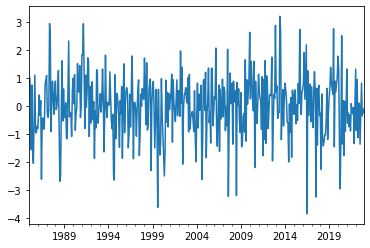

In [56]:
residuos_arma = resultado_arma.resid
residuos_arma.plot()
plt.show()

Os resíduos aparentam ter uma média em torno de zero, com pouca tendência.

#### Normalidade

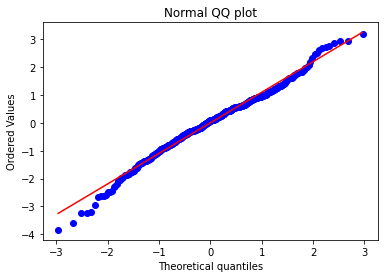

In [57]:
stats.probplot(residuos_arma, dist="norm", plot=plt)
plt.title("Normal QQ plot")
plt.show()

C:\Users\jahon\AppData\Local\Temp\ipykernel_3124\3134224917.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




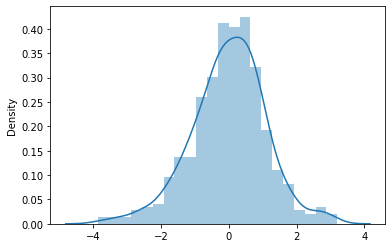

In [58]:
sns.distplot(residuos_arma);

In [59]:
e, p = stats.shapiro(residuos_arma)
print('Estatística de teste: {}'.format(e))
print('p-valor: {}'.format(p))

Estatística de teste: 0.9884341955184937
p-valor: 0.0011298784520477057


O valor está próximo do limite do teste de hipótese e o gráfico se comporta de maneira similar ao de uma distribuição normal, mas os resíduos **não seguem uma distribuição normal**.

#### Autocorrelação

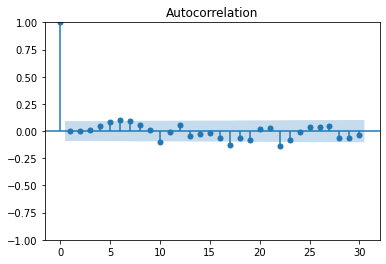

In [60]:
plot_acf(residuos_arma, lags=30)
plt.show()

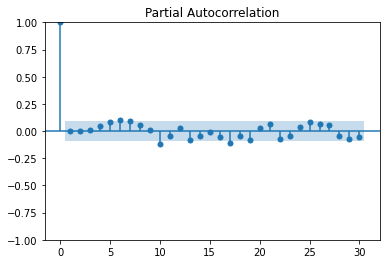

In [61]:
plot_pacf(residuos_arma, lags=30)
plt.show()

Verificando os gráficos do ACF e do PACF, notamos que alguns valores estão fora do intervalo de confiança, apontando para a **existência de autocorrelação nos resíduos**, mesmo que fraca

In [62]:
fig = go.Figure()
_ = serie_n-residuos_arma

fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

### Previsão

In [71]:
184.9**(1/3)

5.696992360135001

In [74]:
aaa = np.diff(serie_n)

In [72]:
np.log(184.9)

5.219815138393079

In [63]:
resultado_arma.fittedvalues

1985-01-31    4.775465
1985-02-28    5.232455
1985-03-31    5.511463
1985-04-30    5.444321
1985-05-31    4.271997
                ...   
2022-08-31    3.478114
2022-09-30    4.263505
2022-10-31    5.240852
2022-11-30    5.921760
2022-12-31    6.088112
Freq: M, Length: 456, dtype: float64

In [64]:
serie_n

1985-01-31    5.696992
1985-02-28    6.239395
1985-03-31    6.126926
1985-04-30    3.892996
1985-05-31    5.015949
                ...   
2022-08-31    3.277285
2022-09-30    5.082627
2022-10-31    4.895150
2022-11-30    5.825532
2022-12-31    5.851932
Freq: M, Length: 456, dtype: float64

In [65]:
previsao_arma = resultado_arma.predict(start=0, end=467)

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=serie_n.index, y=serie_n.values,
                    mode='lines',
                    name='Série histórica'))
fig.add_trace(go.Scatter(x=serie_n.index, y=_,
                    mode='lines',
                    name='Resíduos'))
fig.add_trace(go.Scatter(x=previsao_arma.index, y=previsao_arma,
                    mode='lines',
                    name='Previsão ARMA'))
fig.update_layout(title='Série histórica de chuvas mensais em São Paulo',
                    xaxis_title='Anos',
                    yaxis_title='Chuvas (mm)')
fig.show()

## **Modelo ARIMA**

Modelo ARIMA: (p,d,q)

### Análise dos resíduos

#### Normalidade

#### Autocorrelação

### Previsão

**Problemas do modelo:**
* resíduos não seguem uma distribuição normal
* autocorrelação dos resíduo

## **Modelo ARMA**

Modelo ARIMA: (p,d,q)

Modelo ARMA: (p,0,q)